In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import math

In [ ]:
DATASET = 'CIFAR10'
batch_size = 512

if DATASET == 'CIFAR10': # 3 * 32 * 32
    norm_mean = torch.tensor([0.4914, 0.4822, 0.4465])
    norm_std = torch.tensor([0.2470, 0.2435, 0.2616])
    transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(norm_mean, norm_std)
    ])
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10)
    test_dataloader = DataLoader(test_set, batch_size=batch_size, num_workers=10)
    
    clamp_min, clamp_max = 0.0, 1.0
    
elif DATASET == 'MNIST':
    transform_MNIST = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_set_MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=transform_MNIST)
    test_set_MNIST = datasets.MNIST(root='./data', train=False, download=True, transform=transform_MNIST)

    train_dataloader = DataLoader(train_set_MNIST, batch_size=batch_size, shuffle=True, num_workers=10)
    test_dataloader = DataLoader(test_set_MNIST, batch_size=batch_size, num_workers=10)
else:
    raise ValueError()

Files already downloaded and verified
Files already downloaded and verified


In [65]:
next(iter(train_dataloader))[0].shape

torch.Size([512, 3, 32, 32])

# Training EBMs using MLE with MCMC sampling

In [6]:
import torch
import torch.nn as nn

# Model p(x) = e^{-E(x)} / Z
class EBM(nn.Module):
    def __init__(self, hidden_dim=256):
        super(EBM, self).__init__()
        
        def gn(c):  # GroupNorm helper
            return nn.GroupNorm(num_groups=32, num_channels=c)

        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 32x32
            gn(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16
            gn(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8
            gn(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 4x4
            gn(512),
            nn.ReLU(inplace=True),
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*4*4, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        feat = self.conv_net(x)
        energy = self.fc(feat)
        return energy.squeeze(-1)
    

class MNIST_EBM(nn.Module):
    def __init__(self, hidden_dim=256):
        super(MNIST_EBM, self).__init__()
        
        def gn(c):  # GroupNorm helper
            # 对于小通道数，设 num_groups=8 更稳定
            return nn.GroupNorm(num_groups=8, num_channels=c)

        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # 28x28
            gn(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14x14
            gn(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 7x7
            gn(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 4x4
            gn(512),
            nn.ReLU(inplace=True),
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*4*4, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        feat = self.conv_net(x)
        energy = self.fc(feat)
        return energy.squeeze(-1)



In [8]:
def langevin_sampling(model, x_init, n_steps=200, step_size=0.01, noise_scale=0.01, clamp=(-1, 1)):
    """
    从能量模型采样
    Args:
        x_init: 初始图像, shape (B, C, H, W)
        model: EBM
        n_steps: Langevin 步数
        step_size: 梯度步长
        noise_scale: 噪声尺度
        clamp: 图像值范围
    Returns:
        x_neg: 采样后的图像
    """
    x: torch.Tensor = x_init.clone().detach()
    for _ in range(n_steps):
        x.requires_grad_(True)
        energy = model(x)
        grad = torch.autograd.grad(energy.sum(), x)[0]
        # Langevin 更新
        noise = torch.randn_like(x) * noise_scale
        x = x - 0.5 * step_size * grad + noise
        # 保持像素范围 [0,1]
        x = x.clamp(*clamp).detach()
    return x


In [9]:
# train
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 1e-5

# MCMC
sample_batchsize = 128
step_size = 0.01
n_steps = 100

image_size = (3, 32, 32)
model = EBM(256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    print("Epoch: ", epoch)
    epoch_nums = len(train_dataloader)
    for idx, (X, _) in enumerate(train_dataloader):
        X = X.to(device)
        E = model(X).mean()
        x0 = torch.randn(sample_batchsize, *image_size).to(device)
        samples = langevin_sampling(model, x0)
        logZ = -model(samples).mean()
        loss = E + logZ
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if idx % 50 == 0 or idx == epoch_nums - 1:
            print(f"E: {E:>7f}, LogZ: {1.0 / batch_size * logZ:>7f} [{idx:>3d}/{epoch_nums:>3d}]")

Epoch:  0
E: 0.182797, LogZ: -0.000987 [  0/391]
E: -5.270617, LogZ: -0.051595 [ 50/391]
E: -17.453487, LogZ: -0.156516 [100/391]
E: -29.700352, LogZ: -0.256825 [150/391]
E: -42.445961, LogZ: -0.354225 [200/391]
E: -55.473385, LogZ: -0.453241 [250/391]
E: -68.591499, LogZ: -0.554678 [300/391]
E: -82.149376, LogZ: -0.658314 [350/391]
E: -93.167671, LogZ: -0.743219 [390/391]
Epoch:  1
E: -93.398224, LogZ: -0.745457 [  0/391]
E: -107.527107, LogZ: -0.853123 [ 50/391]
E: -121.769760, LogZ: -0.963758 [100/391]
E: -136.862091, LogZ: -1.077994 [150/391]
E: -152.158417, LogZ: -1.195213 [200/391]
E: -167.910721, LogZ: -1.315781 [250/391]
E: -183.992401, LogZ: -1.439725 [300/391]
E: -200.719711, LogZ: -1.567442 [350/391]
E: -214.400421, LogZ: -1.672557 [390/391]
Epoch:  2
E: -214.770416, LogZ: -1.675282 [  0/391]
E: -232.212524, LogZ: -1.809535 [ 50/391]
E: -250.293243, LogZ: -1.948158 [100/391]
E: -267.929504, LogZ: -2.089964 [150/391]
E: -287.836060, LogZ: -2.235832 [200/391]
E: -307.319397, L

In [1]:
n_samples = 5

model.eval()

# 初始噪声
x_init = torch.rand(n_samples, 3, 32, 32, device=device)

# 使用训练时的 Langevin 更新函数
x = langevin_sampling(model, x_init, n_steps=10000)

# 可视化：保存一个网格
grid = make_grid(x.cpu(), nrow=8, normalize=True, scale_each=True)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Langevin Samples")
plt.imshow(grid.permute(1, 2, 0))

NameError: name 'model' is not defined

# Score Matching

## Model fitting

In [86]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(8, out_channels)
        )
        self.shortcut = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.block(x) + self.shortcut(x))

class ScoreCNN(nn.Module):
    def __init__(self, channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, 64, 3, padding=1),
            nn.SiLU(),
            ResidualBlock(64, 128),
            nn.AvgPool2d(2),
            ResidualBlock(128, 128),
            nn.AvgPool2d(2),
            ResidualBlock(128, 128),
            nn.Upsample(scale_factor=2, mode='nearest'),
            ResidualBlock(128, 128),
            nn.Upsample(scale_factor=2, mode='nearest'),
            ResidualBlock(128, 64),
            nn.Conv2d(64, channels, 3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Denoising score matching
device = torch.device('cuda')

lr = 1e-3
epoch_nums = 150
noise_scale = 0.01

model = ScoreCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

with open('./log.txt', "w") as f:
    f.write()

for epoch in range(epoch_nums):
    for idx, (x, _) in enumerate(train_dataloader):
        x = x.to(device)
        x_noise = x + noise_scale * torch.randn_like(x)
        score = model(x_noise)
        target = (x - x_noise) / (noise_scale ** 2)
        loss = ((score - target) ** 2).sum(dim=(1, 2, 3)).mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_norm = 0
        nums = 0
        #for p in model.parameters():
        #    if p.grad is not None:
        #        total_norm += p.grad.data.norm(2).item()
        #        nums += 1
        #print("grad norm:", total_norm / nums)
    message = f"epoch:{epoch}, loss:{loss.item()}"
    print(message)
    with open('./log.txt', "a") as f:
         f.write(message + "\n")
    
        

## LangevinMCMC Sampling

In [69]:
def LangevinMCMC(score: nn.Module, x_init: torch.Tensor, step_size=0.01, n_steps=200, clamp=[-0.1, 1.1]):
    noise_scale = torch.sqrt(torch.tensor(2 * step_size))
    x = x_init.detach().clone()
    with torch.no_grad():
        for idx in range(n_steps):
            x = x + step_size * score(x) + noise_scale * torch.randn_like(x)
            x = x.clamp(*clamp)
    return x


In [134]:
# 加载模型
def load_ddp_checkpoint_to_model(model, checkpoint_path='checkpoint.pt'):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    state_dict = checkpoint['model']
    
    # 去掉 'module.' 前缀
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    return model


model = ScoreCNN().to(device)
load_ddp_checkpoint_to_model(model, checkpoint_path='v2-checkpoint.pt')

/tmp/ipykernel_274275/4204980143.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


ScoreCNN(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): SiLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 128, eps=1e-05, affine=True)
      )
      (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (act): SiLU()
    )
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): SiLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): GroupNorm(8, 128, eps=1e-05, affine=True)
      )
      (shortcut): Identity()

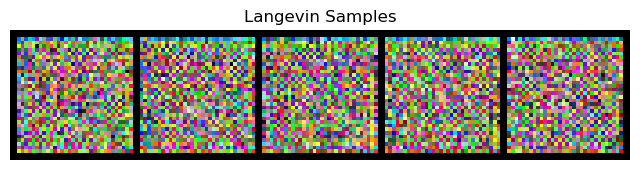

In [137]:
n_samples = 5

model.eval()

# 初始噪声
x_init = torch.rand(n_samples, 3, 32, 32, device=device)

# 使用训练时的 Langevin 更新函数
x = LangevinMCMC(model, x_init, n_steps=1000, clamp=[0, 1])


# 可视化：保存一个网格
grid = make_grid(x.cpu(), nrow=8, normalize=True, scale_each=True)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Langevin Samples")
plt.imshow(grid.permute(1, 2, 0))

### 检验LangevinMCMC的正确性

In [145]:
def Gaussian_score(x):
    return -x

x_init = torch.rand(1000) * 10 - 5 # Uniform[-5, 5)
samples = LangevinMCMC(Gaussian_score, x_init, clamp=(-5, 5))

In [146]:
from scipy.stats import kstest, norm, shapiro

# 假设你的样本为 x
stat, p_value = kstest(samples, 'norm')
print(f"K-S statistic = {stat:.4f}, p-value = {p_value:.4f}")

stat, p_value = shapiro(samples)
print(f"Shapiro-Wilk statistic = {stat:.4f}, p-value = {p_value:.4f}")

K-S statistic = 0.0403, p-value = 0.0754
Shapiro-Wilk statistic = 0.9983, p-value = 0.4050


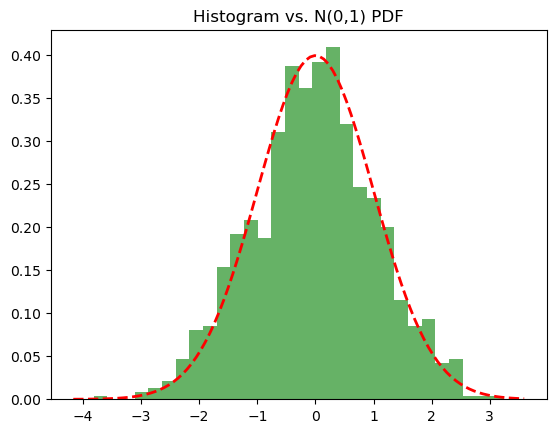

In [147]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 100)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1), 'r--', linewidth=2)
plt.title("Histogram vs. N(0,1) PDF")
plt.show()
